In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2108691176766102694
xla_global_id: -1
]


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from pathlib import Path
import os

## Separating Databases

In [6]:


live_training_dir = 'data/train/live'
spoof_training_dir = 'data/train/spoof'

In [7]:


train_dir =  "data/train"
test_dir = "data/test"

BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing


In [8]:



traingen = train_generator.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 16564 images belonging to 2 classes.
Found 2922 images belonging to 2 classes.
Found 9599 images belonging to 2 classes.


## Creating Model

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

In [10]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = ResNet50(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Training with fine-tuning

In [11]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from sklearn.metrics import accuracy_score

In [12]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=1

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
resnet_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)

In [13]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='models/resnet_50_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

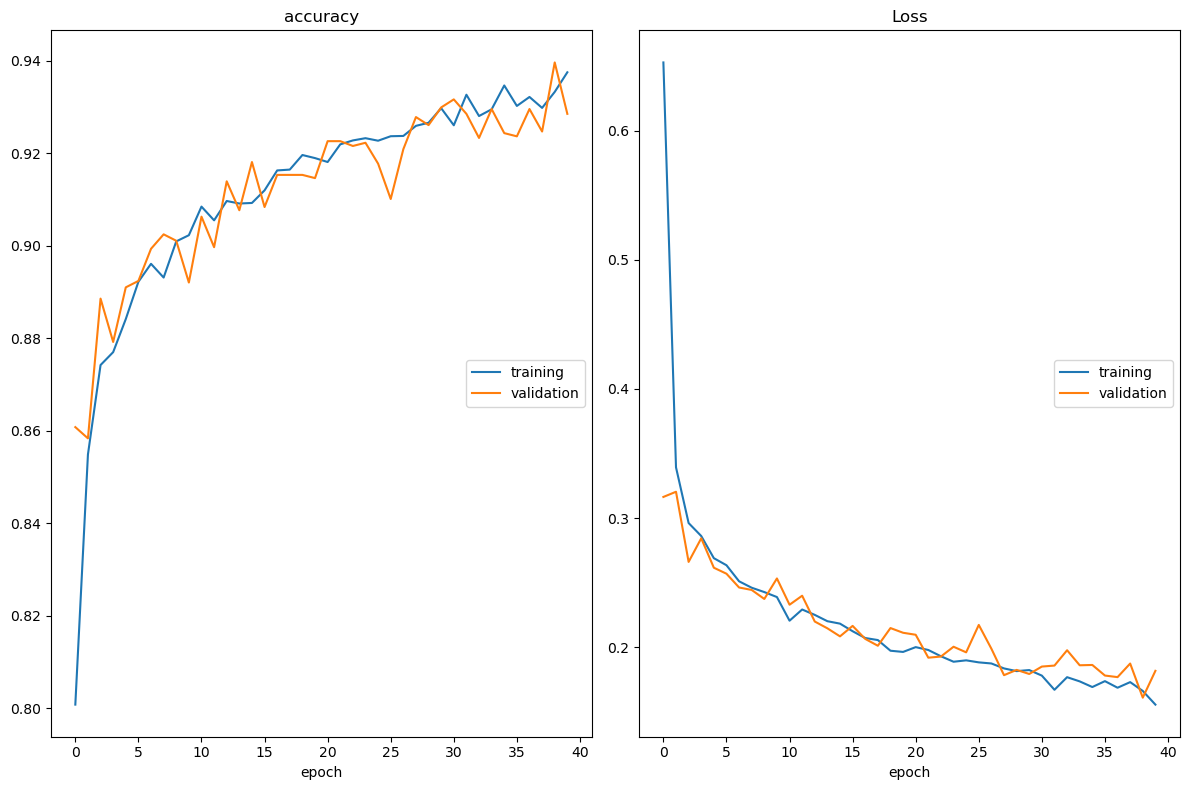

accuracy
	training         	 (min:    0.801, max:    0.937, cur:    0.937)
	validation       	 (min:    0.858, max:    0.940, cur:    0.928)
Loss
	training         	 (min:    0.156, max:    0.653, cur:    0.156)
	validation       	 (min:    0.161, max:    0.320, cur:    0.182)
258/258 [==============================] - 1599s 6s/step - loss: 0.1556 - accuracy: 0.9375 - val_loss: 0.1818 - val_accuracy: 0.9285
Epoch 41/90
203/258 [======================>.......] - ETA: 5:00 - loss: 0.1558 - accuracy: 0.9371

In [37]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
resnet_ft_history = resnet_model.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

## Model Evaluation

In [14]:
# Generate predictions
resnet_model.load_weights('models/resnet_50_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = resnet_model.predict(testgen)
vgg_pred_classes_ft =(vgg_preds_ft > 0.5).astype(int) 

9599/9599 [==============================] - 2834s 295ms/step


In [17]:
true_classes = testgen.classes
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("ResNet50 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))


ResNet50 Model Accuracy with Fine-Tuning: 94.69%


In [18]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(true_classes, vgg_pred_classes_ft, average='binary')
print('precision: ', precision)
print('recall: ', recall)
print('fscore: ', fscore)
print('support: ', support)

precision:  0.9941137998691956
recall:  0.9276777540433323
fscore:  0.9597474348855565
support:  None
